In [1]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 5
import seaborn as sns
sns.set_style("darkgrid")

# Exploratory Data Analysis

In [2]:
# Load training set
dataset = pd.read_csv('./input/train.csv', index_col = 'PassengerId')
target = 'Survived'
features = [c for c in list(dataset.columns.values) if c != target]

# size of the dataset
print('Dataset = {:d} observations x {:d} features (including target)'.format(dataset.shape[0], dataset.shape[1]))
# list of features
dataset.sample(5)

Dataset = 891 observations x 11 features (including target)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
458,1,1,"Kenyon, Mrs. Frederick R (Marion)",female,NaN,1,0,17464,51.8625,D21,S
867,1,2,"Duran y More, Miss. Asuncion",female,27.0,1,0,SC/PARIS 2149,13.8583,NaN,C
651,0,3,"Mitkoff, Mr. Mito",male,NaN,0,0,349221,7.8958,NaN,S
81,0,3,"Waelens, Mr. Achille",male,22.0,0,0,345767,9.0000,NaN,S
839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S


In [3]:
summary = pd.DataFrame(np.array([dataset.dtypes, 
                                 dataset.isnull().sum(), 
                                 dataset.nunique()]),
                       index=['Dtype', 'NbrNullValues', 'NbrDistinctVal'],                       
                       columns=np.array(list(dataset)))
display(summary)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Dtype,int64,int64,object,object,float64,int64,int64,object,float64,object,object
NbrNullValues,0,0,0,0,177,0,0,0,0,687,2
NbrDistinctVal,2,3,891,2,88,7,7,681,248,147,3


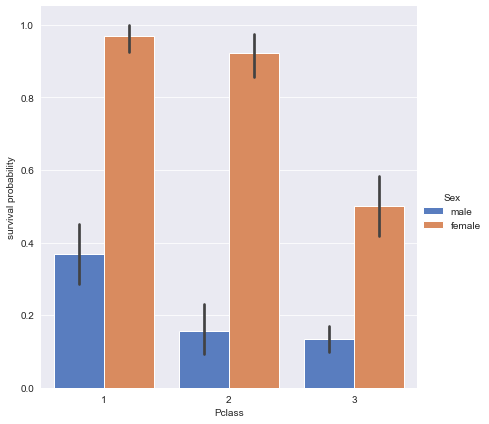

In [4]:
# visualization of interactions btw survival and sex/class 
g = sns.catplot(x='Pclass', y=target, hue='Sex', data=dataset, height=6, kind='bar', palette='muted');
g.despine(left=True)
g.set_ylabels("survival probability")

C:\Users\CEDRIC\Anaconda3\envs\keras-tf\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\CEDRIC\Anaconda3\envs\keras-tf\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


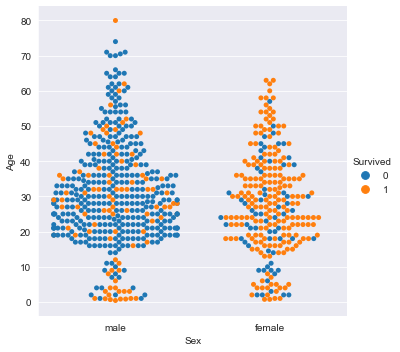

In [5]:
sns.catplot(x='Sex', y='Age', hue='Survived', data=dataset, kind='swarm');

## FE

In [6]:
def prepare_data(data):
    df = data.copy()
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['FamilyName'] = df['Name'].apply(lambda x: x.split(',')[0])
    # remove left/right space characters, and replace other space characters with an underscore 
    df['FamilyName'] = df['FamilyName'].apply(lambda x: x.strip().replace(' ', '_'))
    
    df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())  
    # group similar values 
    df['Title'].replace(['Mr','Don','Rev','Dr','Major','Sir','Col','Capt','Jonkheer'], 'Mr', inplace=True) 
    df['Title'].replace(['Mrs','Mme','Lady','the Countess','Dona'], 'Mrs', inplace=True)     
    df['Title'].replace(['Miss','Ms','Mlle'], 'Miss', inplace=True)
    # passenger 797 Dr. Leader is a female and is misclassified. Should be corrected
    df.loc[(df.Sex == 'female') & (df.Title == 'Mr'), 'Title'] = 'Mrs'
    return df
    
data_prepared = prepare_data(dataset)  
data_prepared.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,FamilyName,Title
PassengerId,,,,,,,,,,,,,,
322,0,3,"Danoff, Mr. Yoto",male,27.0,0,0,349219,7.8958,NaN,S,1,Danoff,Mr
229,0,2,"Fahlstrom, Mr. Arne Jonas",male,18.0,0,0,236171,13.0000,NaN,S,1,Fahlstrom,Mr
334,0,3,"Vander Planke, Mr. Leo Edmondus",male,16.0,2,0,345764,18.0000,NaN,S,3,Vander_Planke,Mr
542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,S,7,Andersson,Miss
862,0,2,"Giles, Mr. Frederick Edward",male,21.0,1,0,28134,11.5000,NaN,S,2,Giles,Mr


In [7]:
print('Max of family size = {:d}'.format(data_prepared.FamilySize.max()))
print('Number of different family names = {:d}'.format(data_prepared.FamilyName.nunique()))

Max of family size = 11
Number of different family names = 667


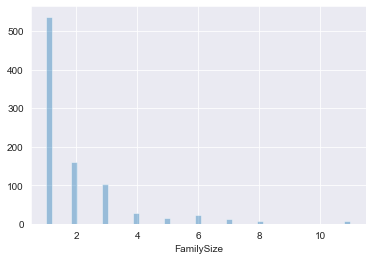

In [8]:
sns.distplot(data_prepared['FamilySize'], kde=False, rug=False);

we need specific mapping to encode family name without ending with too many new features.
OneHotEncoding only for calues with FamilySize above a given minimum family size.

In [9]:
# define transformer to transform high cardinality variables to numerical functions
#### TODO remove hardcoded labels

class FamilyNameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, minimum_count=2):
        self._ignore_values = []
        self._minimum_count = minimum_count
    
    def fit(self, X, y=None):
        # get list of all values of FamilyName with FamilySize less than minimum_count
        df = X.loc[X.FamilySize < self._minimum_count, ['FamilyName']]        
        self._ignore_values = df['FamilyName'].unique().tolist()
        return self
    
    def transform(self, X, y=None):
        df = X.copy()        
        df['FamilyName'].replace(to_replace=self._ignore_values, value=np.NaN, inplace=True)
#        df = pd.get_dummies(df, prefix='Family', dummy_na=False, columns=['FamilyName'], drop_first=False)        
        return df
    
    def get_frequencies(self):        
        return self._frequencies
    
    def get_mapper(self):
        return self._mapper   
    
# example: transform 2 categorical values to numeric functions    
tr = FamilyNameTransformer(minimum_count=5)
tr.fit(data_prepared)
res = tr.transform(data_prepared)
res.sample(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,FamilyName,Title
PassengerId,,,,,,,,,,,,,,
351,0,3,"Odahl, Mr. Nils Martin",male,23.0,0,0,7267,9.2250,NaN,S,1,NaN,Mr
548,1,2,"Padro y Manent, Mr. Julian",male,NaN,0,0,SC/PARIS 2146,13.8625,NaN,C,1,NaN,Mr
368,1,3,"Moussa, Mrs. (Mantoura Boulos)",female,NaN,0,0,2626,7.2292,NaN,C,1,NaN,Mrs


## Model

In [10]:
features = [col for col in list(data_prepared) if col != target]
X = data_prepared[features]
y = data_prepared[[target]]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,FamilyName,Title
PassengerId,,,,,,,,,,,,,
301,3,"Kelly, Miss. Anna Katherine ""Annie Kate""",female,NaN,0,0,9234,7.7500,NaN,Q,1,Kelly,Miss
312,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,5,Ryerson,Miss
112,3,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,NaN,C,2,Zabour,Miss
173,3,"Johnson, Miss. Eleanor Ileen",female,1.0,1,1,347742,11.1333,NaN,S,3,Johnson,Miss
427,2,"Clarke, Mrs. Charles V (Ada Maria Winfield)",female,28.0,1,0,2003,26.0000,NaN,S,2,Clarke,Mrs


In [11]:
ct = ColumnTransformer( transformers = 
                       [('tr_sex', OrdinalEncoder(), ['Sex']),
                        ('tr_class', OneHotEncoder(categories='auto', drop='first'), ['Pclass']),
                        ('tr_name', OneHotEncoder(categories='auto', drop=None), ['Pclass']),                        
                        ('tr_age', SimpleImputer(), ['Age', 'Fare'])],                       
                      remainder='drop', sparse_threshold=0)
tmp = ct.fit_transform(X_train)
print(tmp.shape)

(668, 8)


In [12]:
model = Pipeline([
    ('name_tr', FamilyNameTransformer(minimum_count=4)),
    ('col', ct),
    ('scaler', StandardScaler()),    
    ('reg', LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=500)),
    ])

In [13]:
model.fit(X_train, y_train['Survived'])
score = model.score(X_valid, y_valid)
print('logistic regression score: {:.4f}'.format(score))

logistic regression score: 0.8027


In [14]:
param_grid = {
    'name_tr__minimum_count': [2,3,4,5],
#    'col__tr_age__strategy': ['mean', 'median'],
    'reg__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
    'reg__C': [0.1, 0.4, 1.0, 2.5],
    }

In [15]:
#for k in model.get_params().keys():
#    print(k)

In [16]:
grid_clf = GridSearchCV(model, param_grid, cv=3, iid=False, verbose=1)
grid_clf.fit(X_train, y_train['Survived']);

grid_clf.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   28.8s finished


{'name_tr__minimum_count': 2, 'reg__C': 0.4, 'reg__l1_ratio': 0.25}

In [17]:
print(grid_clf.best_score_)

0.7949002814473666
